In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# import sympy as sp

import os
import sys
sys.path.append("../../Functions")
from calcium_constants import *

from numpy.polynomial import Polynomial

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

In [83]:
plt.rcParams['figure.figsize'] = [11.7, 8.3]
plt.rcParams.update({'font.size': 24})

from matplotlib.pyplot import cm
cm = plt.get_cmap('turbo')

In [ ]:
%matplotlib qt

In [3]:
# This class allows to compute the solution for Duffing equation

class Duffing_analytical():
    '''
    Model the Duffing equation as in Akerman, find the roots of the amplitude equation.
    '''
    def __init__(self,
                 sigma,
                 V_tkl_factor,
                 B = None,
                 cooling_rate = None,
                 nl_damping_rate = None,
                 lam_397=None,
                 P_397=None):
        self.sigma = sigma # detuning between tickle frequency and HO frequency (omega_t - omega_0)
        self.V_tkl_factor = V_tkl_factor # factor applied to the voltage
        self.B = B if B is not None else 1.24*1e18 *4*np.pi**2 # anharmonicity

        self.lam_397 = lam_397 if lam_397 is not None else 396.959120*1e-9 # cooling laser wavelength
        self.P397 = P_397 if P_397 is not None else 100*1e-6 # cooling laser power

        self.cooling_parameters()

        self.cooling_rate = cooling_rate if cooling_rate is not None else self.Gamma # 2*28*2*np.pi
        self.nl_damping_rate = nl_damping_rate if nl_damping_rate is not None else 0.03566372451203145 # Computed from Akerman

    def set_params(self):
        # The prefactor 0.0002076... is computed from Akerman
        # taking value of k and comparing to the force
        # exerted by endcaps as if it was a capacitor
        # k = F/m = qV/(md) <=> V = ...
        self.V_tkl = 0.00020768959957006468 * self.V_tkl_factor
        self.phi_nw = 0
        
        self.omega_z = 422500 *2*np.pi # secular frequency of the ion
        self.omega_z_2 = self.omega_z **2
        # omega_z = omega_z if type(omega_z) is (list or numpy.ndarray) else 422500*2*np.pi
        # omega_z_2 = omega_z **2

        # NW coupling parametrers
        self.d_offset = 33e-6
        self.d_nw = 250e-6 + self.d_offset
        self.z_nw = 100e-6 * self.d_nw / (self.d_nw-self.d_offset)
        self.omega_nw = 422500*2*np.pi
        self.phi_nw = self.phi_nw *np.pi/180 # 0 * np.pi/180 # np.pi

        self.V_nw = 0 # 1

        self.V_piezo = 0 # 5
        self.A_nw  = 184.41690653263915e-9*self.V_piezo
        self.eps = Coul_factor*C_e*1.84*1e-15*self.V_nw

        # tickle parameters
        self.d_tkl = 3e-3 /2
        self.omega_t = self.omega_z
        self.phi_t = np.pi*0

        # coupling parameters
        # amplitude of drives
        self.A1 = ( - self.eps/(self.d_nw**3) * (1 - 3*self.z_nw**2/self.d_nw**2) ) * self.A_nw # nw drive
        self.kappa = 0.03 # kappa = 0.03451
        self.A2_tkl = -C_e*self.kappa*self.V_tkl/self.d_tkl # tickle drive, k*m in Akerman

    def cooling_parameters(self):
        # cooling parameters
        # Gamma = 30e3
        self.w397 = (240/2)*1e-6 # 50e-6 # laser beam radius
        self.k397 = 2*np.pi/self.lam_397
        self.f_397 = c_light/self.lam_397

        self.detuning = (self.f_397 - f_397_Wan)*2*np.pi
        self.intensity = 4*self.P397/(np.pi*self.w397**2)
        # satI = 2*hbar*np.pi**2*c_light/(3*lam_397**3)*Gamma_SP
        self.satI = hbar*(2*np.pi*self.f_397)**3/(12*np.pi*c_light**2)*Gamma_SP
        self.sat0 = self.intensity/self.satI

        self.beta = -4*self.detuning/Gamma_SP * self.sat0 / (1+self.sat0+4*(self.detuning/Gamma_SP)**2)**2 # no unit
        self.Gamma = self.beta * hbar*self.k397**2/m_Ca # friction from laser cooling

    def params_print(self):
        print('Parameters')
        print(f'NW  : A1/m = {self.A1/m_Ca:.3e}')
        print(f'Tkl : A2/m = {self.A2_tkl/m_Ca:.3e}')

        print(f'Saturation = {self.sat0:.5e}')
        print(f'Detuning = {self.detuning/Gamma_SP:.5e} Gamma')

        print(f'Beta = {self.beta:.5e}') # no unit
        print(f'Gamma = {self.Gamma:.5e}')

        print(f'B = {self.B:.5e}')
        print(f'cooling_rate = {self.cooling_rate:.5e}') # 2.86013e+04
        print(f'nl_damping_rate = {self.nl_damping_rate:.5e}')

    def params_return(self):
        return self.A1/m_Ca, self.A2_tkl/m_Ca, self.sat0, self.detuning/Gamma_SP, self.beta,\
            self.Gamma ,self.B ,self.cooling_rate ,self.nl_damping_rate

    def find_roots(self):
        '''
        Find the roots of a the sixth order ploynomial (Eq. 5 from Akerman).
        '''
        self.A6 = 9/16*(self.B**2 + self.nl_damping_rate**2*self.omega_z**6)
        self.A0 = -(self.A2_tkl/m_Ca)**2

        p_roots = np.zeros((len(self.sigma),6),dtype=np.complex128)

        for i, j in enumerate(self.sigma):
            self.A4 = 3*self.omega_z*(self.cooling_rate*self.nl_damping_rate*self.omega_z**3 - j*self.B)
            self.A2 = 4*self.omega_z**2*(j**2 + self.cooling_rate**2)
            self.coeffs = [self.A0,0,self.A2,0,self.A4,0,self.A6]
            p = Polynomial(self.coeffs)
            # p_roots.append( p.roots() )
            p_roots[i] = p.roots()

        return p_roots, self.sigma

    def ss_phase(self,a):
        '''
        Phase of the oscillator (Eq. 3 from Akerman).
        '''
        return 8*self.cooling_rate*self.omega_z / (3*self.B*a**2 - self.omega_z*self.sigma)

In [4]:
detuning = -12*Gamma_SP
# detuning = (np.linspace(-25,0,25+1)[1::4] - 4)*Gamma_SP # (f_397 - f_397_Wan)*2*np.pi
print(detuning/Gamma_SP)
f_397 = (detuning + f_397_Wan*2*np.pi)/2/np.pi
lam_397 = 299792458/f_397

print(lam_397*1e9)

sigma = np.linspace(-2000*2*np.pi,4000*2*np.pi,5001)

V_tkl_factor = 5
B = 1.24*1e18 *4*np.pi**2
cooling_rate = 2*28 *2*np.pi
nl_damping_rate = 0.03566372451203145
REIN = Duffing_analytical(sigma,
                           V_tkl_factor,
                           B,
                           lam_397 = lam_397,
                           P_397 = 100e-6)

REIN.set_params()
p_roots, _ = REIN.find_roots()
REIN.params_print()

-12.0
396.9591149615596
Parameters
NW  : A1/m = -0.000e+00
Tkl : A2/m = -5.000e+04
Saturation = 1.96178e+01
Detuning = -1.20000e+01 Gamma
Beta = 2.64544e-03
Gamma = 1.05024e+03
B = 4.89532e+19
cooling_rate = 1.05024e+03
nl_damping_rate = 3.56637e-02


In [5]:
'''
beam radius 25 um

-12.0
396.9591149615596
Parameters
NW  : A1/m = -0.000e+00
Tkl : A2/m = -5.000e+04
Saturation = 4.51993e+02
Detuning = -1.20000e+01 Gamma
Beta = 2.04903e-02
Gamma = 8.13462e+03
B = 4.89532e+19
cooling_rate = 8.13462e+03
nl_damping_rate = 3.56637e-02
'''

'\nbeam radius 25 um\n\n-12.0\n396.9591149615596\nParameters\nNW  : A1/m = -0.000e+00\nTkl : A2/m = -5.000e+04\nSaturation = 4.51993e+02\nDetuning = -1.20000e+01 Gamma\nBeta = 2.04903e-02\nGamma = 8.13462e+03\nB = 4.89532e+19\ncooling_rate = 8.13462e+03\nnl_damping_rate = 3.56637e-02\n'

In [6]:
from sympy import exp, latex, pprint, series, simplify, factor
from sympy.abc import x, k, s, v, gamma, delta
# from sympy.series.formal import compute_fps

## Some tests

In [7]:
polynome = 1 + x + x**2 + x**3
exp_rate = exp(k*x)
scattering_rate = 0.5*gamma*s/(1+s+4*((delta-k*v)/gamma)**2)

In [8]:
print( simplify( series( polynome, x, 0, 3) ) )
print( simplify( series( exp_rate, x, 0, 3) ) )

1 + x + x**2 + O(x**3)
1 + k*x + k**2*x**2/2 + O(x**3)


## Fluorescence scattering rate of a Doppler cooled ion

Different computations of the Scattering rate $R_s(v)$ vs. velocity $v$. I use three methods for the Taylor expansions : Wolfram Alpha, SymPy, SciPy. I compare them together to make sure everything is right. Then compare them to the analytical solution.

### From SymPy

You need to define some variables in the SymPy style, see `from sympy` ...

In [ ]:
series( scattering_rate, v, 0, 4)

In [ ]:
simplify( series( scattering_rate, v, 0, 4 ) )

In [ ]:
# Copy the output of this cell as the SymPy Taylor expansion
print( simplify( series( scattering_rate, v, 0, 4 ) ) )

### Wolfram Alpha

Now variables will be defined numerically as usual in Python.

In [145]:
v = np.linspace(0,100,1000)

lam_397 = 396.959120*1e-9 # 396.959120*1e-9  396.95916031195106
k397 = 2*np.pi/lam_397
f_397 = c_light/lam_397
delta = (f_397 - f_397_Wan)*2*np.pi

P397 = 75e-6
w397 = 120e-6

intensity = 4*P397/(math.pi*w397**2)
satI = hbar*(2*math.pi*f_397)**3/(12*math.pi*c_light**2)*Gamma_SP # sat intensity
sat0 = intensity/satI

gamma = Gamma_SP
print(delta/gamma)
s = sat0 # 4.40 # 19.6

print(s)

-12.444401089476123
14.713326710566314


In [ ]:
v = np.linspace(-10,110,1001)

lam_397 = 396.95916031195106e-09 # 396.959120*1e-9  396.95916031195106
k = 2*np.pi/lam_397
f_397 = c_light/lam_397
delta = (f_397 - f_397_Wan)*2*np.pi

gamma = Gamma_SP
print(delta/gamma)
s = 14.7133311930 # 19.6

In [ ]:
v = np.linspace(-10,250,1001)

lam_397 = 3.969591206304119e-07 # 396.959120*1e-9  396.95916031195106
k = 2*np.pi/lam_397
f_397 = c_light/lam_397
delta = (f_397 - f_397_Wan)*2*np.pi

gamma = Gamma_SP
print(delta/gamma)
s = 15 # 14.7133311930 # 19.6

In [110]:
def K_scattering_rate_3_WolframAlpha(gamma,s,k,delta):
    # Constant terms of Taylor expansion
    Rs_0 = 1/(1+s+4*(delta/gamma)**2)
    K_Rs_0 = Rs_0 * gamma/2*s
    K_Rs_1 = + 8/gamma**2*delta * Rs_0**2 * k * gamma/2*s # 4/gamma*delta *Rs_0**2 * k * s
    K_Rs_2 = - 4/gamma**2 * (s-12/gamma**2*delta**2+1) * Rs_0**3 * k**2 * gamma/2*s
    K_Rs_3 = - 4*16/gamma**4 * delta * ((s+1) - 4/gamma**2*delta**2) * Rs_0**4 * k**3 * gamma/2*s

    return K_Rs_0, K_Rs_1, K_Rs_2, K_Rs_3, Rs_0

In [111]:
K_Rs_0, K_Rs_1, K_Rs_2, K_Rs_3, Rs_0 = K_scattering_rate_3_WolframAlpha(gamma,s,k397,delta)

# I obtain the Taylor expansion to third order using Wolfram Alpha (Mathematica)
# I removed the null terms
# with gamma, s, k and delta set to their values.
# Scattering rate vs. velocity v.

# Rs_0 = 1/(1+s+4*(delta/gamma)**2)
# Rs_1 = + 2*k*v*4/gamma**2*delta * Rs_0**2
# Rs_2 = - 4/gamma**2 * k**2*v**2 * (s-12/gamma**2*delta**2+1) * Rs_0**3
# Rs_3 = - 4*16/gamma**4 * k**3*v**3 * delta * ((s+1) - 4/gamma**2*delta**2) * Rs_0**4

Rs_WolframAlpha = (K_Rs_0+K_Rs_1*(v)**1+K_Rs_2*(v)**2+K_Rs_3*(v)**3)

print(Rs_0)
print(K_Rs_0, K_Rs_1, K_Rs_2, K_Rs_3)
renorm = hbar*k397/m_Ca
print(renorm * K_Rs_0, renorm * K_Rs_1, renorm * K_Rs_2, renorm * K_Rs_3)
print(renorm * K_Rs_1/2/2/np.pi)

0.0015743920705963347
1569725.77759289 -28734.57260664072 391.1642627809991 -4.692215986839044
39371.222224234436 -720.7088395715057 9.811022623165277 -0.11768824910630828
-57.35218717391446


In [112]:
scattering_rate = 0.5*gamma*s/(1+s+4*((delta-k397*v)/gamma)**2)

### SymPy with the right values

In [113]:
# Formula computed from the symbolic SymPy thing
# with gamma, s, k and delta set to their values.

Rs_3_sympy = 0.5*gamma**3*s*(gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2)\
     - gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2/(4*delta**2 + gamma**2*s + gamma**2) - (-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))**3 + (-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))**2 + 1)/(4*delta**2 + gamma**2*s + gamma**2) +\
         0.5*gamma**3*s*v*(24*delta*k397*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))**2/(4*delta**2 + gamma**2*s + gamma**2) - 16*delta*k397*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2) + 8*delta*k397/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2) +\
         0.5*gamma**3*s*v**2*(-128*delta**2*k397**2*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2)**2 + 64*delta**2*k397**2/(4*delta**2 + gamma**2*s + gamma**2)**2 - 4*k397**2*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))**2/(4*delta**2 + gamma**2*s + gamma**2) + 8*k397**2*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2) - 4*k397**2/(4*delta**2 + gamma**2*s + gamma**2) - (64*delta**2*k397**2/(4*delta**2 + gamma**2*s + gamma**2)**2 + 8*k397**2*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2))*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2)))/(4*delta**2 + gamma**2*s + gamma**2) +\
             0.5*gamma**3*s*v**3*(128*delta*k397**3*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2)**2 - 64*delta*k397**3/(4*delta**2 + gamma**2*s + gamma**2)**2 + 8*delta*k397*(64*delta**2*k397**2/(4*delta**2 + gamma**2*s + gamma**2)**2 + 8*k397**2*(-gamma**2*s/(4*delta**2 + gamma**2*s + gamma**2) + gamma**2*(s + 1)/(4*delta**2 + gamma**2*s + gamma**2) - gamma**2/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2))/(4*delta**2 + gamma**2*s + gamma**2)
# print(Rs_3_sympy)

### Scipy

In [114]:
from scipy.interpolate import approximate_taylor_polynomial
def scattering_rate(v,gamma,s,k,delta):
    return 0.5*gamma*s/(1+s+4/gamma**2*(delta-k*v)**2)

In [115]:
Rs_scipy = approximate_taylor_polynomial(lambda v: scattering_rate(v,gamma,s,k397,delta), 0, 3, 0.01)

# Rs_scipy = approximate_taylor_polynomial(lambda v: scattering_rate(v,gamma,s,k,delta), 0, 7, 0.005)

## Analytical

In [116]:
# The scattering rate as obtained analytically
# with gamma, s, k and delta set to their values.

Rs_analytical = scattering_rate(v,gamma,s,k397,delta)

# Plotting vs. velocity

### Analytical vs. Taylor up to third-order

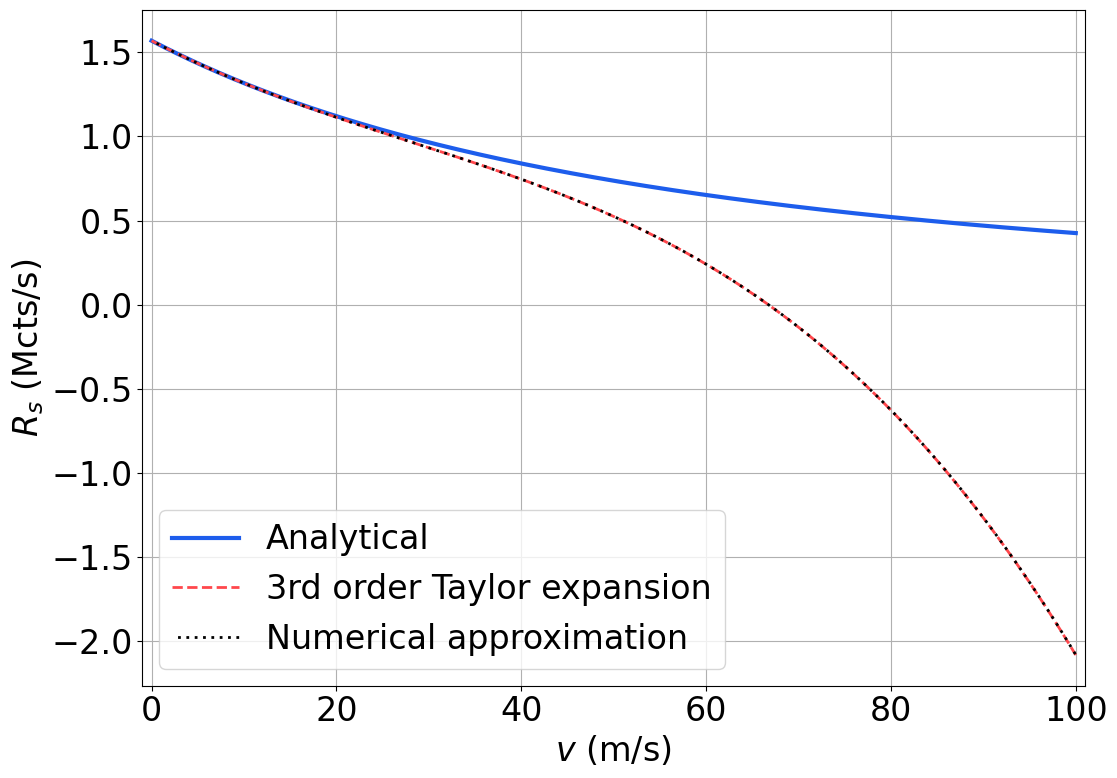

In [117]:
figname = 'Taylor_Swift'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

ax.plot(v,Rs_analytical*1e-6,
    ls='-',lw=3,
    color='xkcd:azul', # royal blue
    marker='',
    label=f'Analytical')

ax.plot(v,Rs_WolframAlpha*1e-6,
    ls='--',lw=2,
    color='xkcd:light red', # royal blue
    marker='',
    label=f'3rd order Taylor expansion')

# ax.plot(v,Rs_3_sympy*1e-6,
#     ls=':',lw=1,
#     color='xkcd:green', # royal blue
#     marker='',
#     label=f'SymPy')

ax.plot(v,Rs_scipy(v)*1e-6,
    ls=(1, (1, 2)),lw=2,
    color='xkcd:black', # royal blue  orange
    marker='',
    label=f'Numerical approximation')

ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$R_s$ (Mcts/s)')

ax.grid()
ax.legend(title='',loc=3)

ax.set_xlim(-1,101)
# ax.set_ylim(-0.75,0.5)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

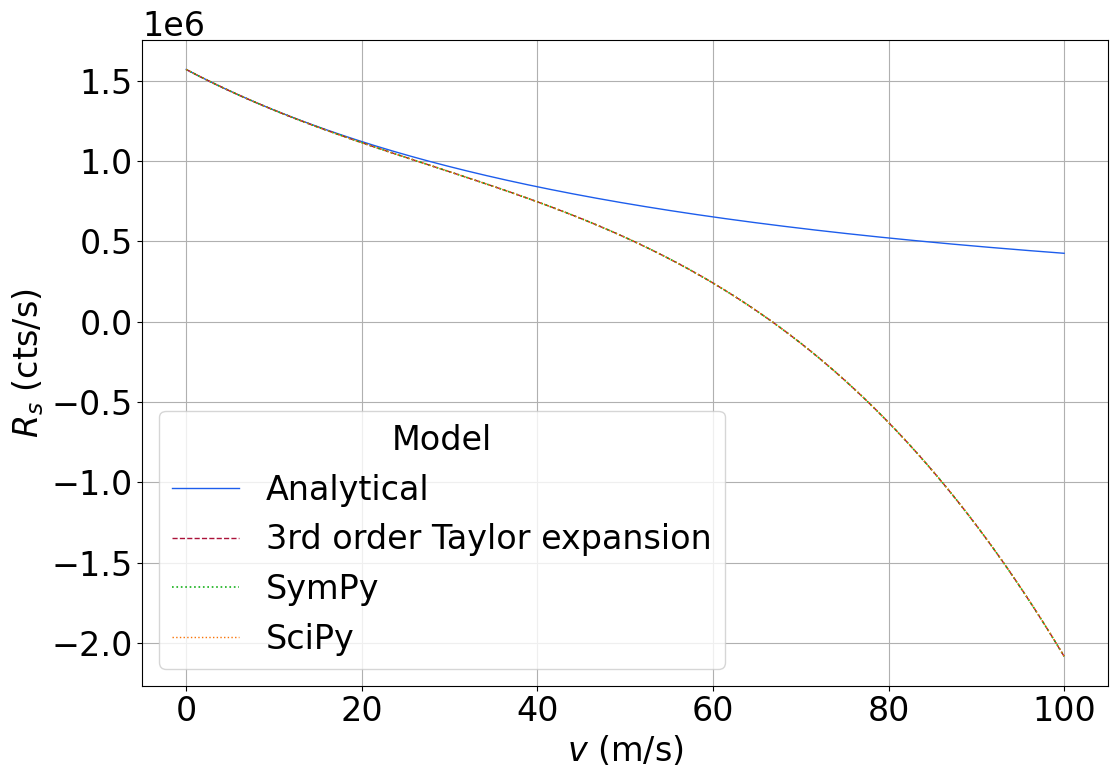

In [118]:
# A zoom to show that among the three models for Taylor expansion
# the SciPy is a bit off.
# this is due to the fact that this is not an exact method but an approximation.
# Quality of approx. depends on 'scale'.

figname = 'Taylor_Swift_zoom'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

ax.plot(v,Rs_analytical,
    ls='-',lw=1,
    color='xkcd:azul', # royal blue
    marker='',
    label=f'Analytical')

ax.plot(v,Rs_WolframAlpha,
    ls='--',lw=1,
    color='xkcd:rouge', # royal blue
    marker='',
    label=f'3rd order Taylor expansion')

ax.plot(v,Rs_3_sympy,
    ls=':',lw=1.2,
    color='xkcd:green', # royal blue
    marker='',
    label=f'SymPy')

ax.plot(v,Rs_scipy(v),
    ls=':',lw=1,
    color='xkcd:orange', # royal blue
    marker='',
    label=f'SciPy')

ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$R_s$ (cts/s)')

ax.grid()
ax.legend(title='Model')

# ax.set_xlim(79,81)
# ax.set_ylim(0.08*1e6,0.10*1e6)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

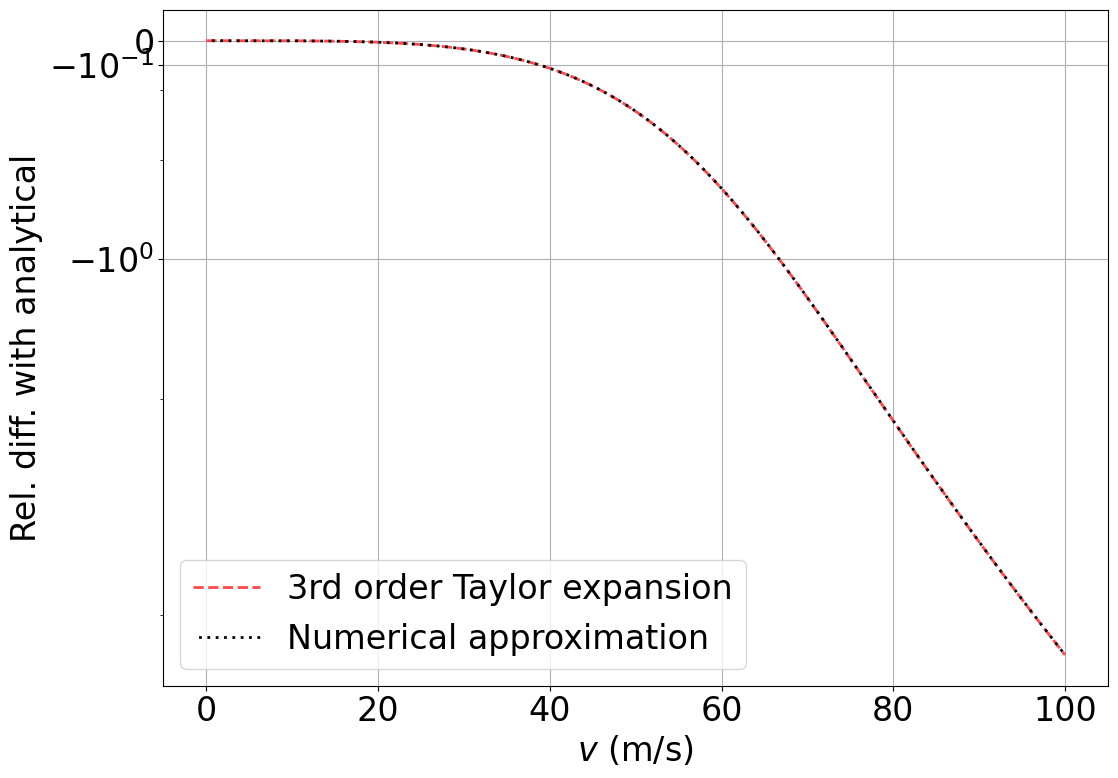

In [119]:
figname = 'Taylor_Swift_rel'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

# ax.plot(v,(Rs_WolframAlpha-Rs_analytical)/np.abs(Rs_analytical),
#     ls='--',lw=2,
#     color='xkcd:light red', # royal blue
#     marker='',
#     label=f'3rd order Taylor expansion')

# ax.plot(v,(Rs_3_sympy-Rs_analytical)/np.abs(Rs_analytical),
#     ls=':',lw=1,
#     color='xkcd:green', # royal blue
#     marker='',
#     label=f'SymPy')

# ax.plot(v,(Rs_scipy(v)-Rs_analytical)/np.abs(Rs_analytical),
    # ls=(1, (1, 2)),lw=2,
    # color='xkcd:black', # royal blue
    # marker='',
    # label=f'Numerical approximation')

# plt.yscale('symlog')

ax.semilogy(v,( (Rs_WolframAlpha-Rs_analytical)/np.abs(Rs_analytical) ),
    ls='--',lw=2,
    color='xkcd:light red', # royal blue
    marker='',
    label=f'3rd order Taylor expansion')

ax.semilogy(v,( (Rs_scipy(v)-Rs_analytical)/np.abs(Rs_analytical) ),
    ls=(1, (1, 2)),lw=2,
    color='xkcd:black', # royal blue
    marker='',
    label=f'Numerical approximation')

ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('Rel. diff. with analytical')

ax.set_yscale('asinh')

ax.grid(axis='both')
ax.legend(title='',loc=3)

# ax.set_xlim(-1,100)
# ax.set_ylim(-6,0.05)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

### More Taylor developments up to 7th order

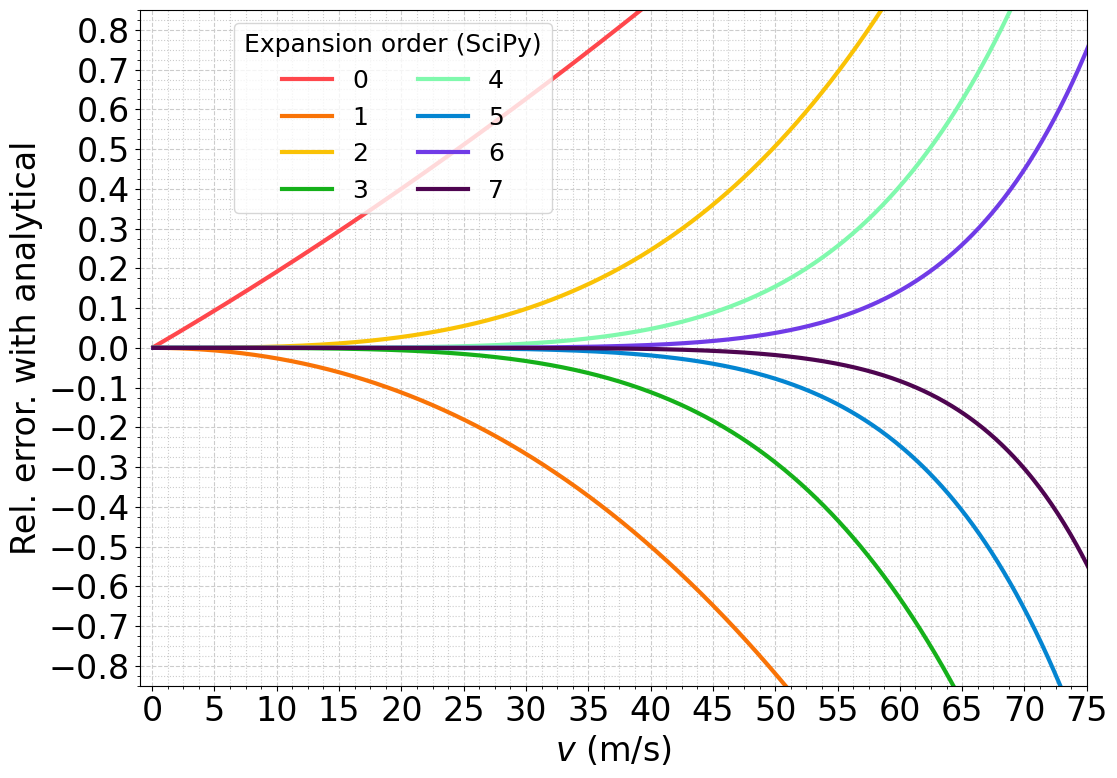

In [147]:
my_color = ['xkcd:light red', 'xkcd:orange', 'xkcd:goldenrod', 'xkcd:green', 'xkcd:seafoam', 'xkcd:cerulean', 'xkcd:bluish purple', 'xkcd:plum purple']
my_scale = [0.005, 0.005, 0.005, 0.005, 0.1, 1, 2, 2]

figname = 'Taylor_Swift_rel_zoom'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

# ax.plot(v,Rs_analytical,
#     ls='-',lw=1,
#     color='xkcd:azul', # royal blue
#     marker='',
#     label=f'Analytical')

for i in range(8):

    Rs_scipy = approximate_taylor_polynomial(lambda v: scattering_rate(v,gamma,s,k397,delta), 0, i, my_scale[i])
    ax.plot(v[1:],(Rs_scipy(v[1:])-Rs_analytical[1:])/np.abs(Rs_analytical[1:]),
        ls='-',lw=3,
        color=my_color[i], # royal blue
        marker='',
        label=f'{i}')

ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('Rel. error. with analytical')

ax.grid()
ax.legend(title='Expansion order (SciPy)',
title_fontsize = 18,
fontsize = 18,
loc=(0.1,0.7),ncols = 2)

ax.set_xlim(-1,75)
ax.set_ylim(-0.85,0.85)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.tight_layout()

plt.savefig(figname+'.png',dpi=300)

### The value for each order independently

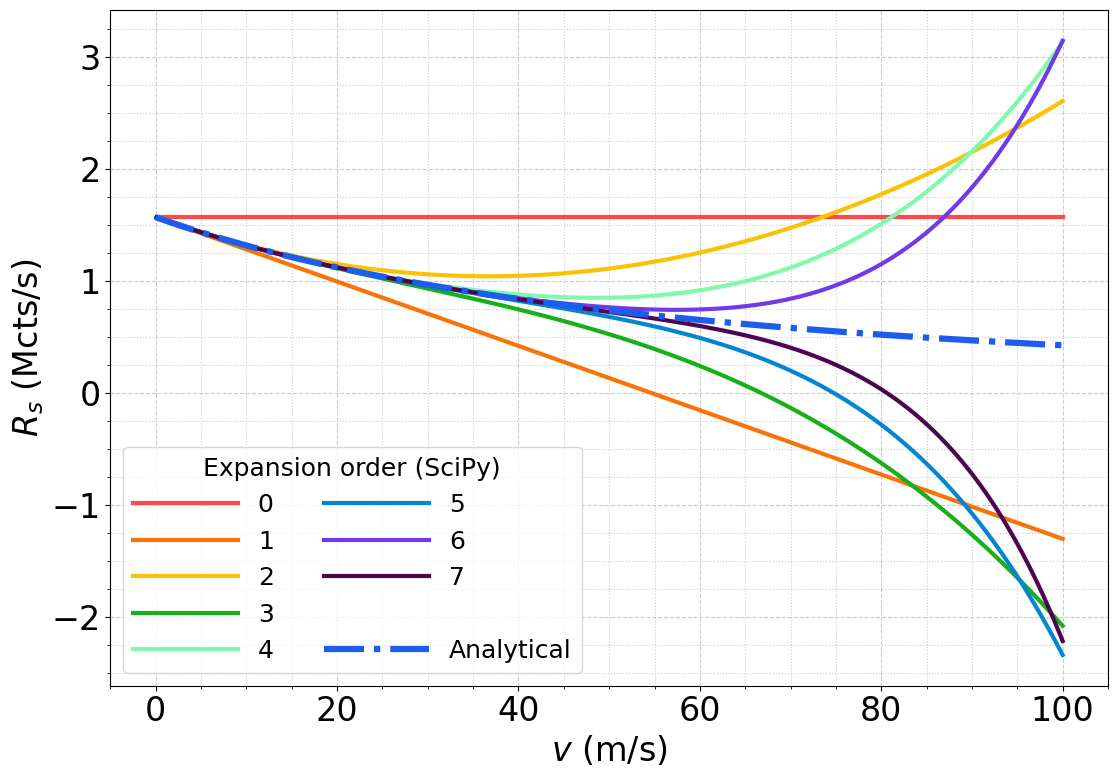

In [144]:
my_color = ['xkcd:light red', 'xkcd:orange', 'xkcd:goldenrod', 'xkcd:green', 'xkcd:seafoam', 'xkcd:cerulean', 'xkcd:bluish purple', 'xkcd:plum purple']
my_scale = [0.005, 0.005, 0.005, 0.005, 0.1, 1, 2, 2]

figname = 'Taylor_terms_scipy'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

for i in range(8):

    Rs_scipy = approximate_taylor_polynomial(lambda v: scattering_rate(v,gamma,s,k397,delta), 0, i, my_scale[i])
    ax.plot(v[1:],Rs_scipy(v[1:])*1e-6,
        ls='-',lw=3,
        color=my_color[i], # royal blue
        marker='',
        label=f'{i}')

ax.plot([0,1],[0,1],
    ls='',lw=4.5,
    color='xkcd:azul', # royal blue
    marker='',
    label=f' ')

ax.plot(v,Rs_analytical*1e-6,
    ls='dashdot',lw=4.5,
    color='xkcd:azul', # royal blue
    marker='',
    label=f'Analytical')

ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('$R_s$ (Mcts/s)')

ax.grid()
ax.legend(title='Expansion order (SciPy)',
title_fontsize = 18,
fontsize = 18,
# loc=(0.1,0.7),
ncols = 2,
handlelength=4.2)

# ax.set_xlim(-1,75)
# ax.set_ylim(-0.25,0.25)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

plt.tight_layout()

plt.savefig(figname+'.png',dpi=300)

-0.0


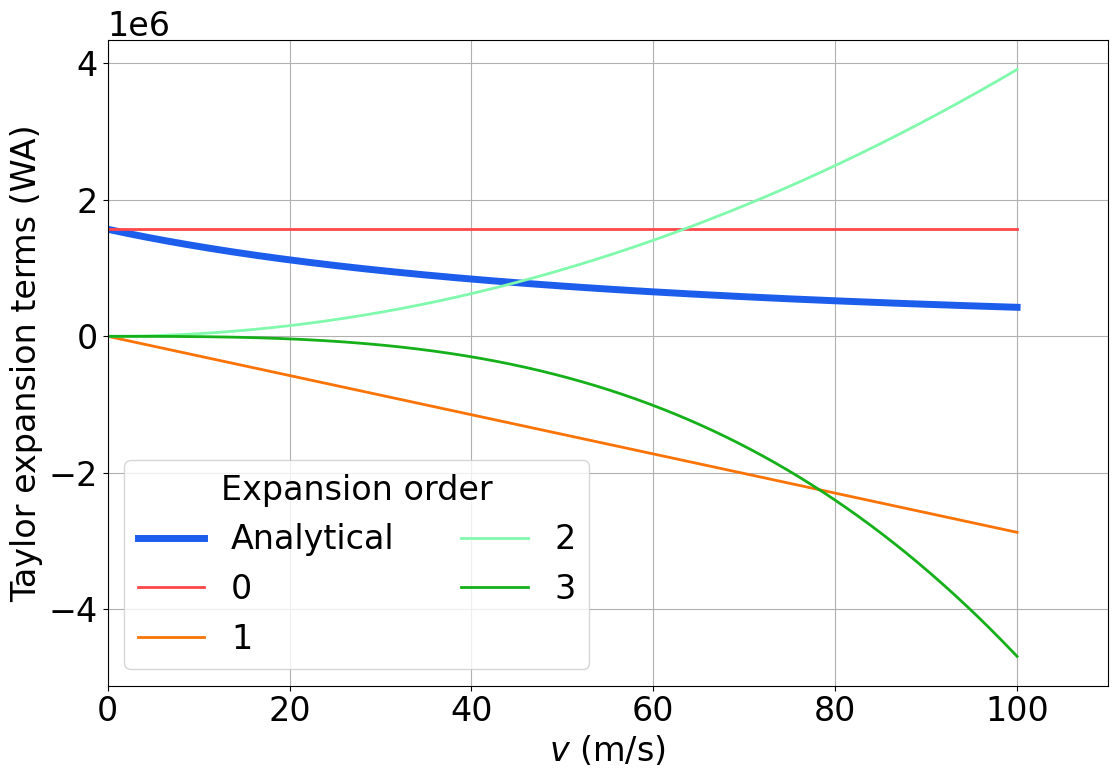

In [100]:
K_Rs_0, K_Rs_1, K_Rs_2, K_Rs_3, Rs_0 = K_scattering_rate_3_WolframAlpha(gamma,s,k397,delta) # delta

figname = 'Taylor_terms_WA'
fig, ax = plt.subplots(1,
                    num=figname,
                    clear=True,sharex=True)

ax.plot(v,Rs_analytical,
    ls='-',lw=5,
    color='xkcd:azul', # royal blue
    marker='',
    label=f'Analytical')


ax.plot(v,K_Rs_0 * np.ones(len(v)),
    ls='-',lw=2,
    color=my_color[0], # royal blue
    marker='',
    label=f'0')
ax.plot(v,K_Rs_1 * v,
    ls='-',lw=2,
    color=my_color[1], # royal blue
    marker='',
    label=f'1')
ax.plot(v,K_Rs_2 * v**2,
    ls='-',lw=2,
    color=my_color[4], # royal blue
    marker='',
    label=f'2')
ax.plot(v,K_Rs_3 * v**3,
    ls='-',lw=2,
    color=my_color[3], # royal blue
    marker='',
    label=f'3')

print(np.max(K_Rs_3* v**3))

# ax.text(2,1.15e6,f's={s:.3f}\n$\delta_0$={delta/Gamma_SP:.3f}$\Gamma$')

ax.set_xlabel('$v$ (m/s)')
ax.set_ylabel('Taylor expansion terms (WA)')

ax.grid()
ax.legend(title='Expansion order',ncols=2)

ax.set_xlim(-0,110)
# ax.set_ylim(-1.75e6,1.2e6)

plt.tight_layout()

# plt.savefig(figname+'.png',dpi=300)

In [101]:
# delta = 

# for i,delta in enumerate(np.linspace(-20,0,11)*Gamma_SP):
for i,s in enumerate(np.linspace(0,200,11)):
    K_Rs_0, K_Rs_1, K_Rs_2, K_Rs_3, Rs_0 = K_scattering_rate_3_WolframAlpha(gamma,s,k397,delta)

    mu2_laser   = -hbar*k397**2/m_Ca * sat0 * 4 * detuning/Gamma_SP * Rs_0**2
    gamma_laser =  hbar*k397**4/m_Ca * sat0 * 32 * detuning/Gamma_SP**3 * (1+sat0-4*(detuning/Gamma_SP)**2) * Rs_0**4

    # print(mu2_laser, gamma_laser)
    # print(renorm * K_Rs_1, renorm * K_Rs_3)

    # print( )
    print(gamma_laser/mu2_laser)

0.0001588149492098665
0.00014905090112545354
0.00014016038396484135
0.00013204222272663333
0.00012460947725881293
0.00011778710484876438
0.00011151005863856592
0.00010572173140883049
0.00010037267486051873
9.541954003338402e-05
9.082419627608628e-05
